In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/GAN_Project/creditcard.csv'
df = pd.read_csv(file_path, on_bad_lines='skip')

print("Shape of the DataFrame:", df.shape)
print(df.head())

Shape of the DataFrame: (120875, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010

<ipython-input-12-d31f9bb6ba00>:4: DtypeWarning: Columns (5,12,14,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, on_bad_lines='skip')


Class
0.0    120605
1.0       239
Name: count, dtype: int64


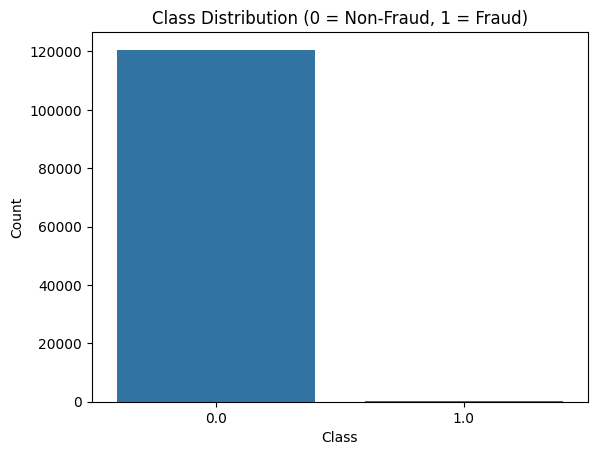


Class Percentages:
Class
0.0    0.998022
1.0    0.001978
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# the number of each category
print(df['Class'].value_counts())

# diagram
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Calculating percentages
class_counts = df['Class'].value_counts(normalize=True)
print("\nClass Percentages:")
print(class_counts)

In [ ]:
#(minority class)
df_fraud = df[df['Class'] == 1]

#(majority class)
df_non_fraud = df[df['Class'] == 0]

#the number of samples in each category
print("Number of fraud samples:", len(df_fraud))
print("Number of non-fraud samples:", len(df_non_fraud))

Number of fraud samples: 239
Number of non-fraud samples: 120605


In [ ]:
from sklearn.preprocessing import StandardScaler

# بشيل ال الأعمدة الغير ضرورية'Time' و'Class'
df_fraud_features = df_fraud.drop(['Time', 'Class'], axis=1)

#Normalization
scaler = StandardScaler()
X_fraud_scaled = scaler.fit_transform(df_fraud_features)

print("Scaled fraud data shape:", X_fraud_scaled.shape)

Scaled fraud data shape: (239, 29)


In [ ]:
import torch

# تحويل الداتا Tensor
X_tensor = torch.tensor(X_fraud_scaled, dtype=torch.float32)

In [ ]:
import torch
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, input_dim=29):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  )
            #values between -1 , 1

    def forward(self, z):
        return self.model(z)

In [ ]:
# Discriminator (ببين اذا الداتا حقيقية  ولا مزيفة)
class Discriminator(nn.Module):
    def __init__(self, input_dim=29):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#Data dimensions
latent_dim = 100
input_dim = X_tensor.shape[1]  # عدد ال features

#creat models
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Loss Function
criterion = nn.BCELoss()

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# DataLoader )(عشان نقسم الداتا لأكتر من دفعة)
from torch.utils.data import DataLoader, TensorDataset
loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

In [ ]:
#epochs
num_epochs = 100

for epoch in range(num_epochs):
    for real_batch in loader:
        real_data = real_batch[0]
        batch_size = real_data.size(0)

        # Labels for real and fake data
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        d_optimizer.zero_grad()

        # Loss for real data
        real_output = discriminator(real_data)
        d_loss_real = criterion(real_output, real_labels)

        # Generate random noise and fake data
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)

        # Loss for fake data
        fake_output = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

         # Total loss for the discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()

        # Generator tries to fool the discriminator into thinking fake data is real!
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()

   # Print results every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [20/100], D Loss: 0.7420, G Loss: 1.1400
Epoch [40/100], D Loss: 0.5574, G Loss: 2.1265
Epoch [60/100], D Loss: 0.5598, G Loss: 2.2713
Epoch [80/100], D Loss: 0.2109, G Loss: 3.8499
Epoch [100/100], D Loss: 0.4382, G Loss: 2.7505


In [ ]:
# Number of samples to generate
num_samples = 500

# Generate random noise
z = torch.randn(num_samples, latent_dim)

# Generate synthetic data
generated_data = generator(z).detach().numpy()

# Revert values back to original scale (Inverse transform)
generated_data_original = scaler.inverse_transform(generated_data)

# Show the shape of generated data
print("Shape of generated data:", generated_data_original.shape)

Shape of generated data: (500, 29)


In [ ]:
# show the first 5 rows
import pandas as pd

# Make sure df_fraud does not include Time and Class columns
df_fraud_clean = df[df['Class'] == 1].drop(['Time', 'Class'], axis=1)

# Create a DataFrame with the generated data
generated_df = pd.DataFrame(generated_data_original, columns=df_fraud_clean.columns)

# Add a new column Class = 1 (for synthetic fraud data)
generated_df['Class'] = 1

# Show the generated samples
print("\nSample of Generated Data:")
print(generated_df.head())


Sample of Generated Data:
         V1        V2         V3        V4        V5        V6        V7  \
0  1.525321  0.136433   0.228169  1.836013 -8.553093 -0.066665  0.344200   
1  1.401995  0.392901  -0.362022  2.006380 -8.887048 -1.592092  0.223612   
2  1.620040  0.040681 -15.522153  6.705643 -9.815001 -3.011173  0.351324   
3  1.163894  1.911773 -13.608825  2.375801 -8.412797 -0.308406  0.168466   
4  1.532449  0.092107  -8.125868  5.341424 -9.206243 -0.297690  0.312825   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -6.174325 -0.349238 -1.715534  ...  5.401593  1.191512 -1.542785 -0.204553   
1 -6.140718 -0.386627 -1.844802  ...  5.546021  1.055244 -0.883172 -0.585003   
2 -6.180892 -5.229855 -1.753622  ...  5.689863 -0.868779 -1.774832 -0.615837   
3 -5.688609 -1.747253 -2.151820  ...  5.042509  1.024265 -1.583360 -0.590815   
4 -6.168855 -0.437647 -1.711059  ...  5.559212  1.187200 -1.724533 -0.346518   

        V25       V26       V27    

In [ ]:
# Split the original data into non-fraud and fraud
df_non_fraud = df[df['Class'] == 0] #all non-fraud transactions (Class=0)
df_fraud_original = df[df['Class'] == 1] #synthetic fraud data (Class=1)

# Combine the data to create a balanced dataset
balanced_df = pd.concat([df_non_fraud, df_fraud_original, generated_df], axis=0)

# Shuffle the rows randomly
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show class distribution after balancing
print(balanced_df['Class'].value_counts())

Class
0.0    120605
1.0       739
Name: count, dtype: int64


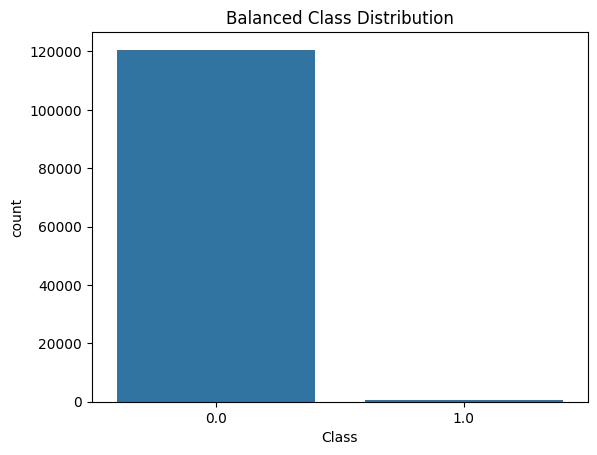

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data=balanced_df)
plt.title('Balanced Class Distribution')
plt.show()

In [ ]:
num_samples = 10000  #Increase the number of generated samples
z = torch.randn(num_samples, latent_dim)
generated_data = generator(z).detach().numpy()
generated_data_original = scaler.inverse_transform(generated_data)

generated_df = pd.DataFrame(generated_data_original, columns=df_fraud_clean.columns)
generated_df['Class'] = 1

balanced_df = pd.concat([df_non_fraud, df_fraud_original, generated_df], axis=0)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['Class'].value_counts())

Class
0.0    120605
1.0     10239
Name: count, dtype: int64


In [ ]:
# Generator و Discriminator for WGAN
import torch
import torch.nn as nn

class WGAN_Generator(nn.Module):
    def __init__(self, latent_dim=100, input_dim=29):
        super(WGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


class WGAN_Critic(nn.Module):  #  بنستخدم ال (Critic) بدل (Discriminator)
    def __init__(self, input_dim=29):
        super(WGAN_Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
latent_dim = 100
input_dim = X_tensor.shape[1]

generator_wgan = WGAN_Generator(latent_dim, input_dim)
critic_wgan = WGAN_Critic(input_dim)

g_optimizer_wgan = torch.optim.RMSprop(generator_wgan.parameters(), lr=0.00005)
c_optimizer_wgan = torch.optim.RMSprop(critic_wgan.parameters(), lr=0.00005)

# DataLoader
from torch.utils.data import DataLoader, TensorDataset
loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

#Training Loop
num_epochs_wgan = 200
n_critic = 5 # Number of times Critic is trained per epoch

for epoch in range(num_epochs_wgan):
    for i, real_batch in enumerate(loader):
        real_data = real_batch[0]
        batch_size = real_data.size(0)

        #Train Critic
        for _ in range(n_critic):
            c_optimizer_wgan.zero_grad()

            # Real loss
            real_loss = -torch.mean(critic_wgan(real_data))

            # Fake loss
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator_wgan(z)
            fake_loss = torch.mean(critic_wgan(fake_data))

            # Total loss
            c_loss = real_loss + fake_loss
            c_loss.backward()
            c_optimizer_wgan.step()

            # Clip critic weights
            for p in critic_wgan.parameters():
                p.data.clamp_(-0.01, 0.01)

        #Train Generator
        g_optimizer_wgan.zero_grad()
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator_wgan(z)
        g_loss = -torch.mean(critic_wgan(fake_data))
        g_loss.backward()
        g_optimizer_wgan.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_wgan}], C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [50/200], C Loss: -0.1259, G Loss: -0.1596
Epoch [100/200], C Loss: -0.1165, G Loss: -0.0825
Epoch [150/200], C Loss: -0.0739, G Loss: -0.1326
Epoch [200/200], C Loss: -0.0988, G Loss: -0.1743


In [ ]:
# Number of samples to generate
num_samples_wgan = 500

# Generate random noise
z_wgan = torch.randn(num_samples_wgan, latent_dim)

# Generate synthetic data
generated_data_wgan = generator_wgan(z_wgan).detach().numpy()

# Revert values back to original scale
generated_data_original_wgan = scaler.inverse_transform(generated_data_wgan)

# Show the shape of generated data
print("Shape of generated data from WGAN:", generated_data_original_wgan.shape)

Shape of generated data from WGAN: (500, 29)


In [ ]:
# creat DataFrame
generated_df_wgan = pd.DataFrame(generated_data_original_wgan, columns=df_fraud_clean.columns)
generated_df_wgan['Class'] = 1

Class
0.0    120605
1.0       739
Name: count, dtype: int64


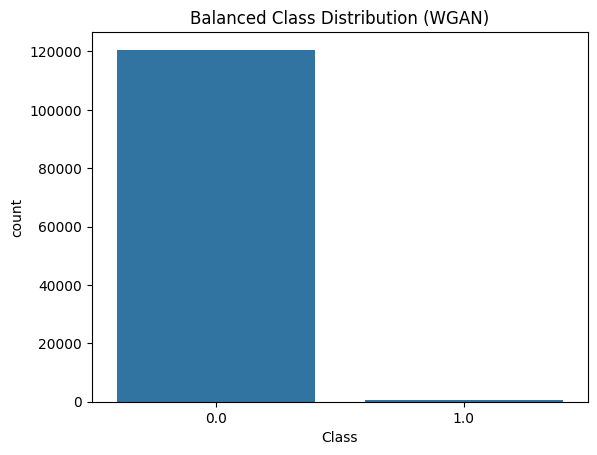

In [ ]:
#Integration Data
balanced_df_wgan = pd.concat([df_non_fraud, df_fraud_original, generated_df_wgan], axis=0)
balanced_df_wgan = balanced_df_wgan.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df_wgan['Class'].value_counts())

sns.countplot(x='Class', data=balanced_df_wgan)
plt.title('Balanced Class Distribution (WGAN)')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Define function to split data
def prepare_data(df):
    X = df.drop('Class', axis=1)
    y = df['Class']
    return train_test_split(X, y, test_size=0.2, random_state=42)

#Clean data before training
for col in df.columns:
    if col not in ['Time', 'Class']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.fillna(0)

#Split original dataset
X = df.drop('Class', axis=1)
y = df['Class']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = prepare_data(df)

#Train model on original data
model_orig = RandomForestClassifier()
model_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = model_orig.predict(X_test_orig)




In [ ]:
#Train model on (Vanilla GAN)
balanced_vanilla = pd.concat([df_non_fraud, df_fraud_original, generated_df], axis=0)
balanced_vanilla = balanced_vanilla.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_vanilla, X_test_vanilla, y_train_vanilla, y_test_vanilla = prepare_data(balanced_vanilla)

model_vanilla = RandomForestClassifier()
model_vanilla.fit(X_train_vanilla, y_train_vanilla)
y_pred_vanilla = model_vanilla.predict(X_test_vanilla)


In [ ]:
#Train model on (WGAN)
balanced_wgan = pd.concat([df_non_fraud, df_fraud_original, generated_df_wgan], axis=0)
balanced_wgan = balanced_wgan.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_wgan, X_test_wgan, y_train_wgan, y_test_wgan = prepare_data(balanced_wgan)

model_wgan = RandomForestClassifier()
model_wgan.fit(X_train_wgan, y_train_wgan)
y_pred_wgan = model_wgan.predict(X_test_wgan)


In [ ]:
#Function to calculate performance metrics
def evaluate(y_true, y_pred, model=None, X_test=None):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if X_test is not None and model is not None:
        auc = roc_auc_score(y_true, model.predict_proba(X_test)[:, 1])
    else:
        auc = float('nan')  # في حال لم يتم توفير احتمالات
    return prec, rec, f1, auc

In [ ]:
#Calculate metrics for each case
prec_orig, rec_orig, f1_orig, auc_orig = evaluate(y_test_orig, y_pred_orig, model_orig, X_test_orig)
prec_vanilla, rec_vanilla, f1_vanilla, auc_vanilla = evaluate(y_test_vanilla, y_pred_vanilla, model_vanilla, X_test_vanilla)
prec_wgan, rec_wgan, f1_wgan, auc_wgan = evaluate(y_test_wgan, y_pred_wgan, model_wgan, X_test_wgan)

In [ ]:
#Display results in a table
results = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Original': [prec_orig, rec_orig, f1_orig, auc_orig],
    'Vanilla GAN': [prec_vanilla, rec_vanilla, f1_vanilla, auc_vanilla],
    'WGAN': [prec_wgan, rec_wgan, f1_wgan, auc_wgan]
}

results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
      Metric  Original  Vanilla GAN      WGAN
0  Precision  0.945946     0.999520  0.978102
1     Recall  0.833333     0.997607  0.943662
2   F1-Score  0.886076     0.998563  0.960573
3    ROC-AUC  0.963313     0.999261  0.978135


<ipython-input-61-ae57d2440a25>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Metric', y='Score', hue='Dataset', data=results_melted, ci=None)


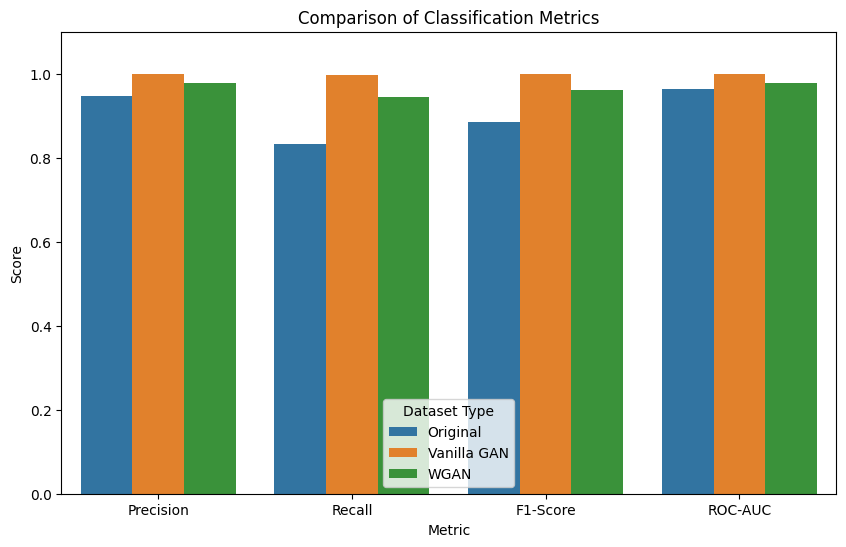

In [ ]:
#Bar chart comparison of metrics
results_melted = results_df.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=results_melted, ci=None)
plt.title('Comparison of Classification Metrics')
plt.ylabel('Score')
plt.legend(title='Dataset Type')
plt.ylim(0, 1.1)
plt.show()